In [1]:
from astropy.timeseries import LombScargle
from astropy import time
from astropy.coordinates import get_sun, EarthLocation, AltAz, solar_system_ephemeris
from astropy import units as un
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('./data/sksolartimevariation5804d.txt', skiprows=13, sep='\s+', names=['t_mean(s)', 't_mean-t_start(s)', 't_end-t_mean(s)', 'nu_flux(1e6cm-2s-1)', 'flux_up_error(1e6cm-2s-1)', 'flux_down_error(1e6cm-2s-1)'])
data

,t_mean(s),t_mean-t_start(s),t_end-t_mean(s),nu_flux(1e6cm-2s-1),flux_up_error(1e6cm-2s-1),flux_down_error(1e6cm-2s-1)
0,833654760,170100,277380,2.74,0.63,0.53
1,834127080,175500,210060,2.83,0.75,0.62
2,834550800,213180,230160,2.30,0.53,0.45
3,834997020,199380,212640,1.79,0.55,0.44
4,835380420,170520,265680,3.15,0.74,0.61
...,...,...,...,...,...,...
1338,1525315550,172739,172774,2.36,0.36,0.33
1339,1525703838,215064,215054,2.26,0.31,0.29
1340,1526138206,216970,216028,1.88,0.33,0.29
1341,1526588224,232102,226109,1.90,0.38,0.28


## Consider the dates after july 2001 and plot ls periodogram of the data, on top of original data.

In [2]:
july1_2001_JS = 1025481600



Divide each bin into about 5 sub-bins \
and calculate the distance in each bin and take the average\

If they are almost the same,then just calculate the distance at the mod-point\
In the end the goal is to multiply the flux provided by this distance**2\



In [3]:
def calculate_distance(date):
    # Set the observer's location on Earth (you can change these coordinates as needed)
    observer_location = EarthLocation(lat=0*un.deg, lon=0*un.deg, height=0*un.m)

    # Set the date for which you want to calculate the distance
    observation_time = time.Time(date)

    # Get the position of the Sun at the specified date
    with solar_system_ephemeris.set('builtin'):
        sun_position = get_sun(observation_time)

    # Transform the Sun's position to Altitude-Azimuth coordinates
    sun_altaz = sun_position.transform_to(AltAz(obstime=observation_time, location=observer_location))

    # Calculate the distance between the Sun and the Earth
    distance = sun_altaz.distance

    return distance

In [4]:
#convert time elapsed (in seconds) since 1st jan 1970 to dd/mm/yyyy format python

def convert_time_to_date(time_elapsed):
    return time.Time(time_elapsed, format='unix').to_datetime()


In [5]:
avg_dists_2 = []
t_mean_days = []
avg_dists_2_from_jul_1_2001 = []
t_mean_days_from_jul_1_2001 = []
times_Jul_1_2001 = []
flux_Jul_1_2001 = []
flux_err_up_Jul_1_2001 = []
flux_err_down_Jul_1_2001 = []
for i in range(len(data)):
    row = data.iloc[i]
    t_start = row['t_mean(s)'] - row['t_mean-t_start(s)']
    t_end = row['t_mean(s)'] + row['t_end-t_mean(s)']
    t_mean_days.append(convert_time_to_date(row['t_mean(s)']).strftime("%Y-%m-%d"))    
    T_bins = np.linspace(t_start, t_end, 6)
    T_bins = convert_time_to_date(T_bins)
    T_bins = np.array([x.strftime("%Y-%m-%d") for x in T_bins])
    # print(T_bins)
    # dists = [calculate_distance(x) for x in T_bins]
    dists = calculate_distance(T_bins)
    # avg_dist = np.mean(dists)
    avg_dists_2.append(dists.mean().value**2)
    # print(dists)
    if t_start <= july1_2001_JS:
        times_Jul_1_2001.append(row['t_mean(s)'])
        flux_Jul_1_2001.append(row['nu_flux(1e6cm-2s-1)'])
        flux_err_up_Jul_1_2001.append(row['flux_up_error(1e6cm-2s-1)'])
        flux_err_down_Jul_1_2001.append(row['flux_down_error(1e6cm-2s-1)'])
        t_mean_days_from_jul_1_2001.append(convert_time_to_date(row['t_mean(s)']).strftime("%Y-%m-%d"))
        avg_dists_2_from_jul_1_2001.append(dists.mean().value**2)


In [6]:
times = data['t_mean(s)'].values * un.s
flux = data['nu_flux(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_up = data['flux_up_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_down = data['flux_down_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6

In [7]:
times_Jul_1_2001 = np.array(times_Jul_1_2001) * un.s
flux_Jul_1_2001 = np.array(flux_Jul_1_2001) * un.cm**-2 * un.s**-1 * 1e6
flux_err_up_Jul_1_2001 = np.array(flux_err_up_Jul_1_2001) * un.cm**-2 * un.s**-1 * 1e6
flux_err_down_Jul_1_2001 = np.array(flux_err_down_Jul_1_2001) * un.cm**-2 * un.s**-1 * 1e6

In [8]:
lsp = LombScargle(times, flux, dy=0.5*(flux_err_up+flux_err_down), normalization='log')
freq, power = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

lsp_d2 = LombScargle(times, np.multiply(flux, avg_dists_2), dy=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), normalization='log')
freq_d2, power_d2 = lsp_d2.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

In [9]:
lsp_Jul_1_2001 = LombScargle(times_Jul_1_2001, flux_Jul_1_2001, dy=0.5*(flux_err_up_Jul_1_2001+flux_err_down_Jul_1_2001), normalization='log')
freq_Jul_1_2001, power_Jul_1_2001 = lsp_Jul_1_2001.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

lsp_d2_Jul_1_2001 = LombScargle(times_Jul_1_2001, np.multiply(flux_Jul_1_2001, avg_dists_2_from_jul_1_2001), dy=np.multiply(0.5*(flux_err_up_Jul_1_2001+flux_err_down_Jul_1_2001), avg_dists_2_from_jul_1_2001), normalization='log')
freq_d2_Jul_1_2001, power_d2_Jul_1_2001 = lsp_d2_Jul_1_2001.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

/home/darkwake/.local/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: divide by zero encountered in divide
  power = YC * YC / CC + YS * YS / SS
/home/darkwake/.local/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:138: RuntimeWarning: invalid value encountered in log
  power = -np.log(1 - power / YY)


In [10]:
freq_943 = freq[np.argmin(np.abs(freq - 9.43/un.year))]
power_943 = power[np.argmin(np.abs(freq - 9.43/un.year))]

freq_d2_943 = freq_d2[np.argmin(np.abs(freq_d2 - 9.43/un.year))]
power_d2_943 = power_d2[np.argmin(np.abs(freq_d2 - 9.43/un.year))]

In [11]:
print(freq_943, power_943)

9.430504478879708 1 / yr 0.0005128729870259506


In [12]:
print(freq_d2_943, power_d2_943)

9.430504478879708 1 / yr 0.0005801569895170708


In [13]:
print(lsp.false_alarm_probability(power_943, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='bootstrap'))

1.0
1.0


In [14]:
print(lsp.false_alarm_probability(power_943, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='naive'))

1.0
1.0


In [15]:
print(lsp.false_alarm_probability(power_943, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='baluev'))

1.0
1.0


In [16]:
freq_max = freq[np.nanargmax(power)]
power_max = power[np.nanargmax(power)]

freq_d2_max = freq_d2[np.nanargmax(power_d2)]
power_d2_max = power_d2[np.nanargmax(power_d2)]

In [17]:
print(freq_max, power_max)
print(freq_d2_max, power_d2_max)

1.0650280243425922 1 / yr 0.012813376887859882
9.394093264714147 1 / yr 0.011791236844139165


In [18]:
print(lsp.false_alarm_probability(power_max, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='bootstrap'))

0.891
0.988


In [19]:
print(lsp.false_alarm_probability(power_max, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='naive'))

0.4661067074807819
0.7120135954552762


In [20]:
print(lsp.false_alarm_probability(power_max, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='baluev'))

0.8453499624335352
0.97125966438681


In [21]:
print(freq_max, freq_d2_max)

1.0650280243425922 1 / yr 9.394093264714147 1 / yr


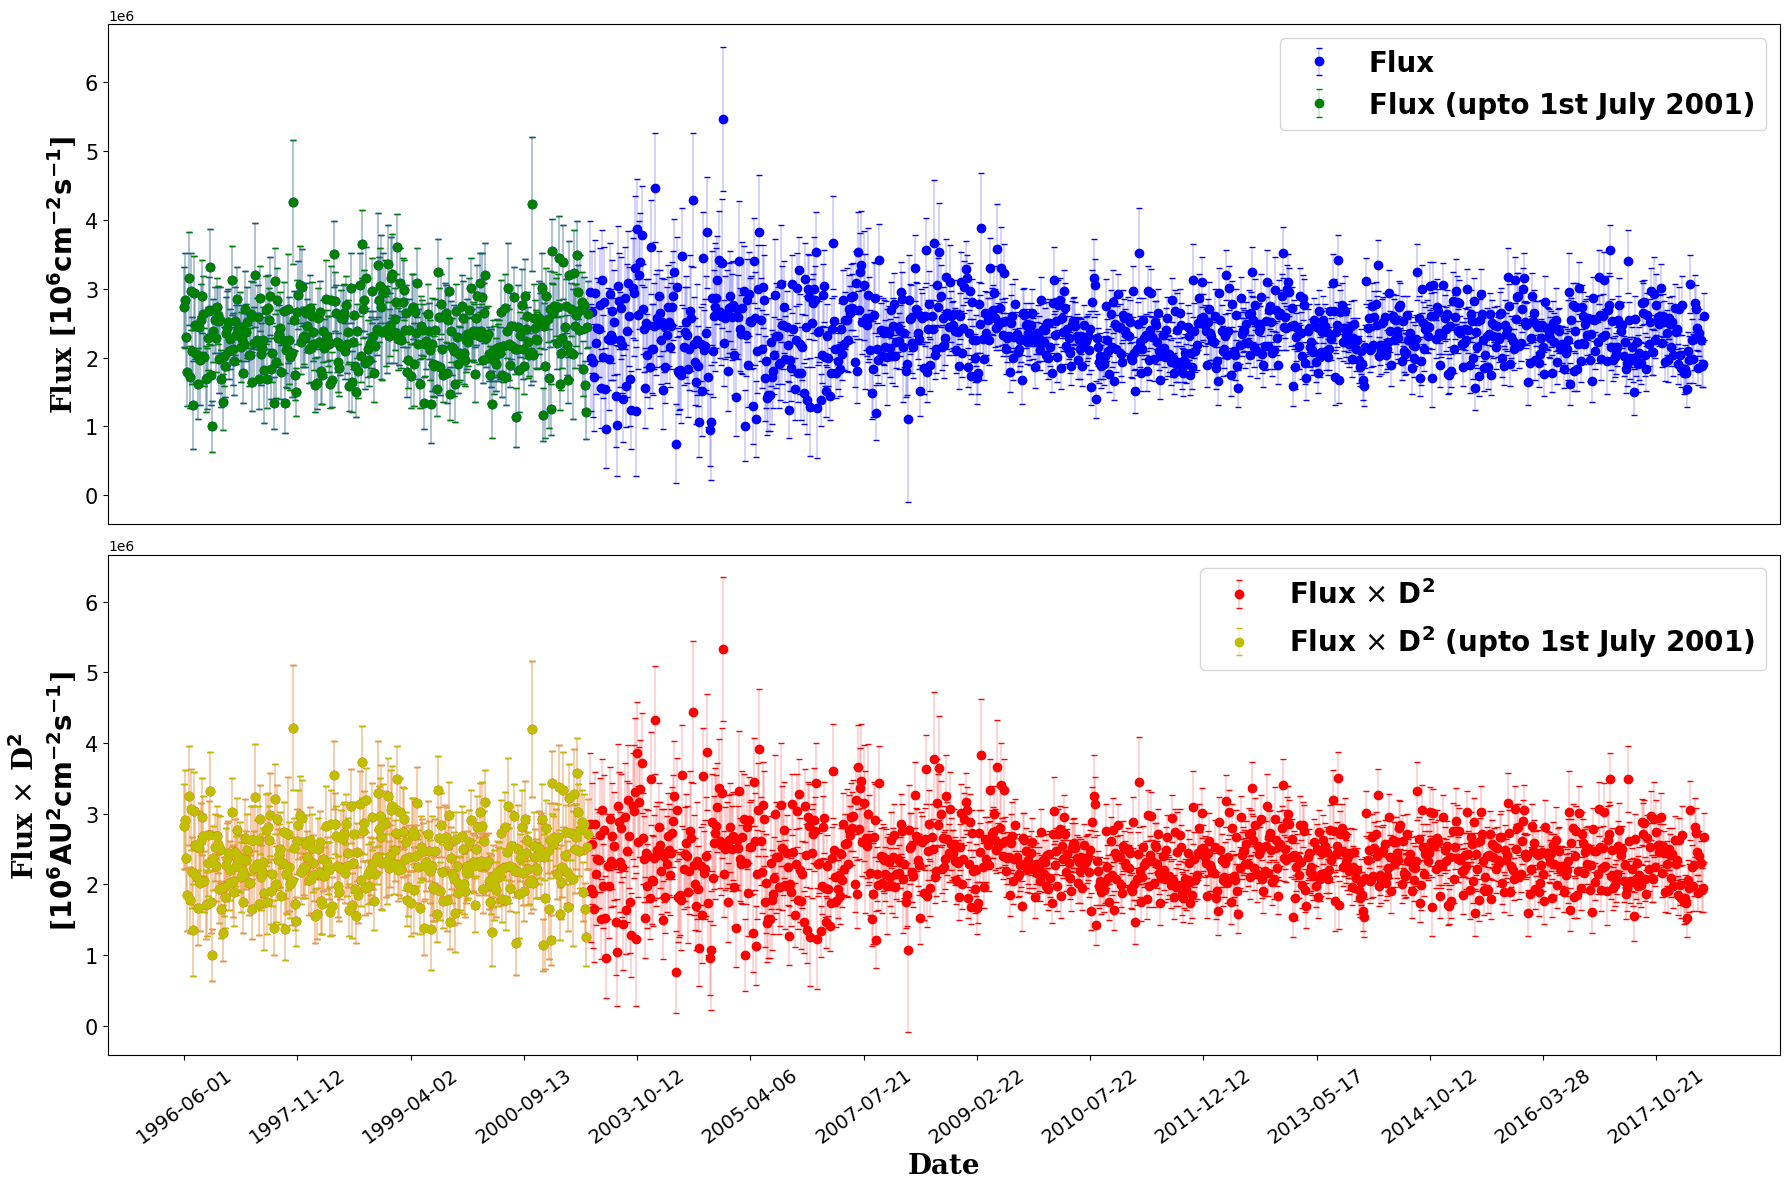

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }

ax[0].errorbar(t_mean_days, flux, yerr=0.5*(flux_err_up+flux_err_down), fmt='o', c='b', elinewidth=0.24, capsize=2, label='Flux')
ax[1].errorbar(t_mean_days, np.multiply(flux, avg_dists_2), yerr=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), fmt='o', c='r', elinewidth=0.24, capsize=2, label='Flux $\\times$ D$\mathbf{^2}$')

ax[0].errorbar(t_mean_days_from_jul_1_2001, flux_Jul_1_2001, yerr=0.5*(flux_err_up_Jul_1_2001+flux_err_down_Jul_1_2001), fmt='o', c='g', elinewidth=0.24, capsize=2, label='Flux (upto 1st July 2001)')
ax[1].errorbar(t_mean_days_from_jul_1_2001, np.multiply(flux_Jul_1_2001, avg_dists_2_from_jul_1_2001), yerr=np.multiply(0.5*(flux_err_up_Jul_1_2001+flux_err_down_Jul_1_2001), avg_dists_2_from_jul_1_2001), fmt='o', c='y', elinewidth=0.24, capsize=2, label='Flux $\\times$ D$\mathbf{^2}$ (upto 1st July 2001)')

ax[0].set_ylabel('Flux [$\mathbf{10^6 cm^{-2} s^{-1}}$]', fontdict=axesfont)


ax[1].set_ylabel('Flux $\\times$ D$\mathbf{^2}$\n [$\mathbf{10^6 AU^{2} cm^{-2} s^{-1}}$]', fontdict=axesfont)

for i in range(2):
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':20, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Date',  fontdict=axesfont)
ax[1].set_xticks(t_mean_days[::100])
ax[1].xaxis.set_tick_params(labelsize=14, rotation=36)
plt.tight_layout()
plt.savefig('./outputs/timeseries_Jul_2001_overlap.pdf')
plt.show()

Power, fre max, 943, etc for >01/07/2001 part

In [23]:
freq_943_jul_1_2001 = freq_Jul_1_2001[np.argmin(np.abs(freq_Jul_1_2001 - 9.43/un.year))]
power_943_jul_1_2001 = power_Jul_1_2001[np.argmin(np.abs(freq_Jul_1_2001 - 9.43/un.year))]

freq_943_d2_jul_1_2001 = freq_d2_Jul_1_2001[np.argmin(np.abs(freq_d2_Jul_1_2001 - 9.43/un.year))]
power_943_d2_jul_1_2001 = power_d2_Jul_1_2001[np.argmin(np.abs(freq_d2_Jul_1_2001 - 9.43/un.year))]

freq_max_jul_1_2001 = freq_Jul_1_2001[np.nanargmax(power_Jul_1_2001)]
power_max_jul_1_2001 = power_Jul_1_2001[np.nanargmax(power_Jul_1_2001)]

freq_d2_max_jul_1_2001 = freq_d2_Jul_1_2001[np.nanargmax(power_d2_Jul_1_2001)]
power_d2_max_jul_1_2001 = power_d2_Jul_1_2001[np.nanargmax(power_d2_Jul_1_2001)]

In [24]:
print(freq_943_jul_1_2001, power_943_jul_1_2001)
print(freq_943_d2_jul_1_2001, power_943_d2_jul_1_2001)

9.431971561475892 1 / yr 0.05564984203778157
9.431971561475892 1 / yr 0.05819007721291212


In [25]:
print(lsp_Jul_1_2001.false_alarm_probability(power_943_jul_1_2001, method='bootstrap'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_943_d2_jul_1_2001, method='bootstrap'))

0.17900000000000005
0.124


In [26]:
print(lsp_Jul_1_2001.false_alarm_probability(power_943_jul_1_2001, method='naive'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_943_d2_jul_1_2001, method='naive'))

0.04487045726623859
0.028822533729650997


In [27]:
print(lsp_Jul_1_2001.false_alarm_probability(power_943_jul_1_2001, method='baluev'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_943_d2_jul_1_2001, method='baluev'))

0.13669388941374075
0.09125832309212072


In [28]:
print(freq_max_jul_1_2001, power_max_jul_1_2001)
print(freq_d2_max_jul_1_2001, power_d2_max_jul_1_2001)

9.431971561475892 1 / yr 0.05564984203778157
9.431971561475892 1 / yr 0.05819007721291212


In [29]:
print(lsp_Jul_1_2001.false_alarm_probability(power_max_jul_1_2001, method='bootstrap'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_d2_max_jul_1_2001, method='bootstrap'))

0.18500000000000005
0.11199999999999999


In [30]:
print(lsp_Jul_1_2001.false_alarm_probability(power_max_jul_1_2001, method='naive'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_d2_max_jul_1_2001, method='naive'))

0.04487045726623859
0.028822533729650997


In [31]:
print(lsp_Jul_1_2001.false_alarm_probability(power_max_jul_1_2001, method='baluev'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_d2_max_jul_1_2001, method='baluev'))

0.13669388941374075
0.09125832309212072


In [32]:
print(lsp_Jul_1_2001.false_alarm_probability(power_max_jul_1_2001, method='davies'))
print(lsp_d2_Jul_1_2001.false_alarm_probability(power_d2_max_jul_1_2001, method='davies'))

0.1469859442774612
0.09569440847823457


In [32]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }

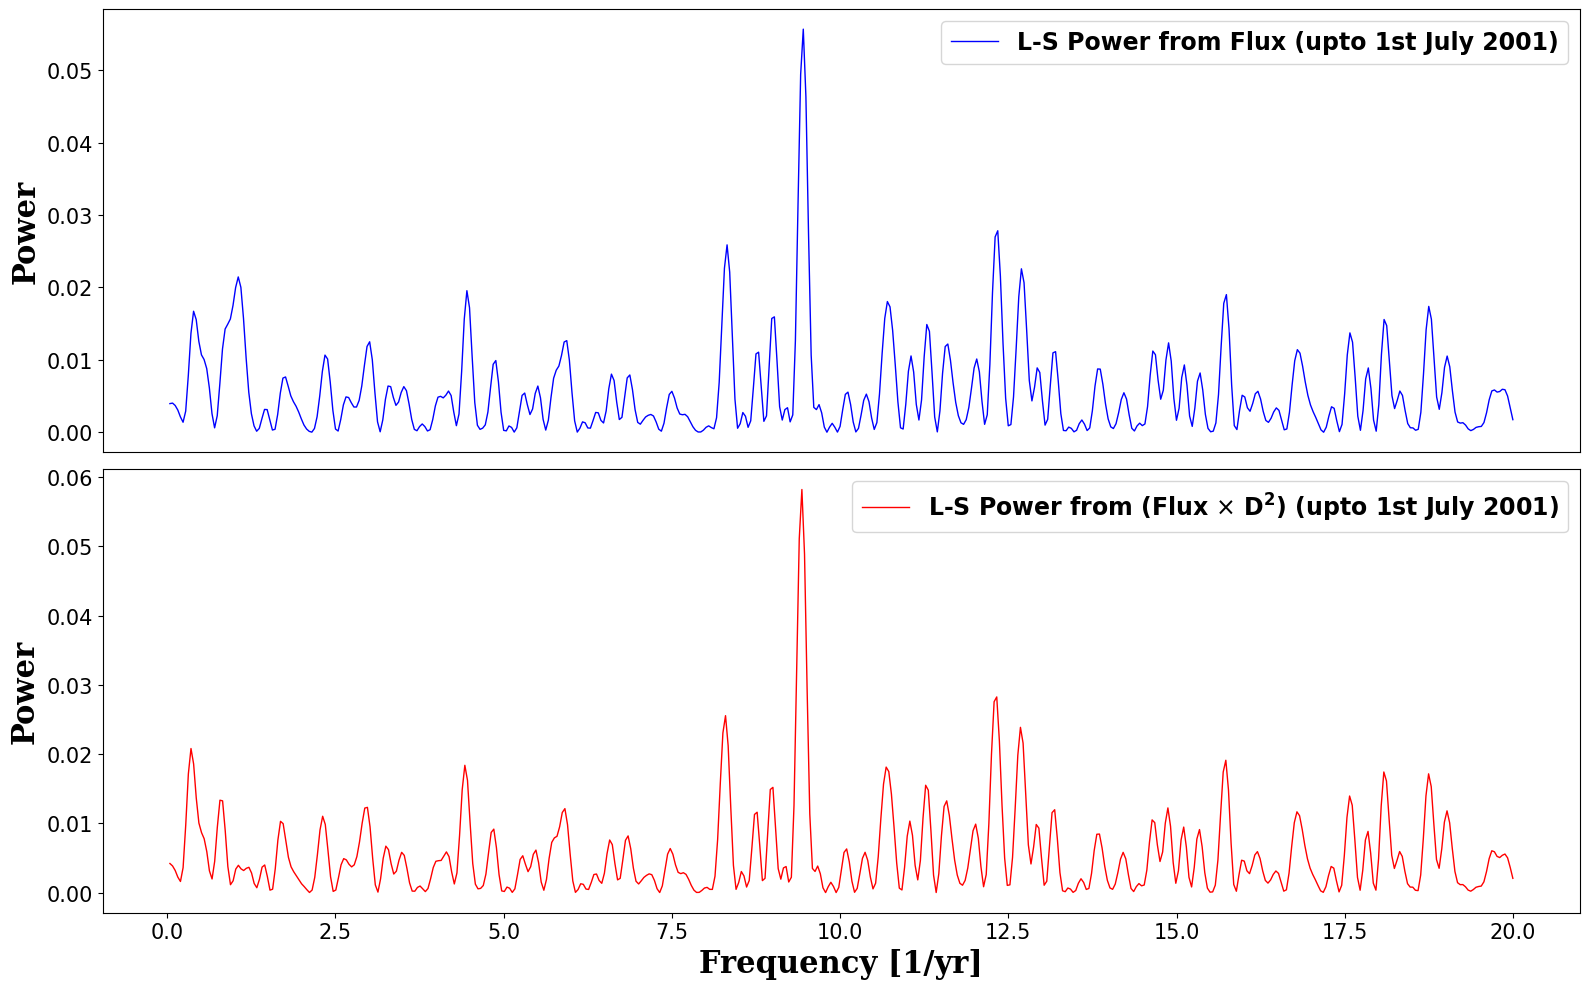

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

# ax[0].plot(freq, power, '-', lw=1, c='b', label='L-S Power from raw flux')
ax[0].plot(freq_Jul_1_2001, power_Jul_1_2001, '-', lw=1, c='b', label='L-S Power from Flux (upto 1st July 2001)')


# ax[0].set_title('Raw Power')
# ax[1].plot(freq_d2, power_d2, '-', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
ax[1].plot(freq_d2_Jul_1_2001, power_d2_Jul_1_2001, '-', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$) (upto 1st July 2001)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})

ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('./outputs/ls_power_upto_Jul_1_2001.pdf', format='pdf')
plt.show()